# Exploration 노드 11
## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

import warnings
warnings.filterwarnings('ignore') #경고 무시

## 시계열 분석을 위한 함수 정의

In [2]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# 1) 삼성전자 주식 예측
## STEP 1. 시계열 데이터 준비
csv 파일에서 각 날짜별 마감시간의 가격으로 시계열 데이터를 준비한다. 

In [3]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [4]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치는 __없다__는 것을 확인할 수 있다. 로그 변환 후에 데이터는 그대로 이용하겠다. 

In [5]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

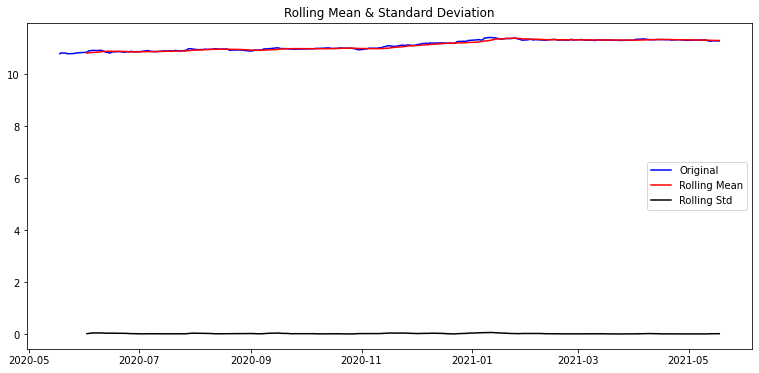

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


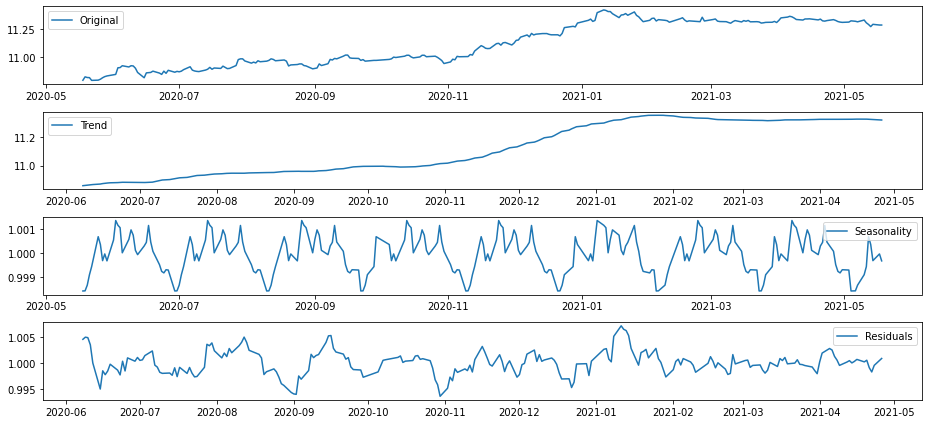

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


p-value가 충분히 작은 것으로 보아 시계열의 안정성이 확보된다는 것을 알 수 있다. 

## STEP 4 : 학습, 테스트 데이터셋 생성
학습과 테스트 데이터를 9:1로 나누어서 다음과 같이 그래프로 표현된다. 

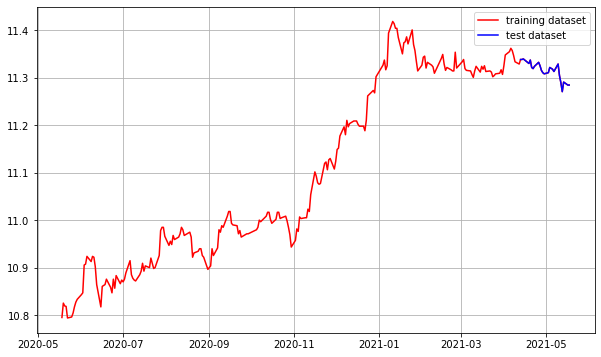

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF(Autocorrelation Function)과 PACF(Partial Autocorrelation Function)을 구하여 ARIMA의 모수인 p와 q를 결정한다. 이후에, 1차 또는 2차 차분까지 구해서 시계열이 안정된 상태이면 그 차수가 모수 d가 된다. 

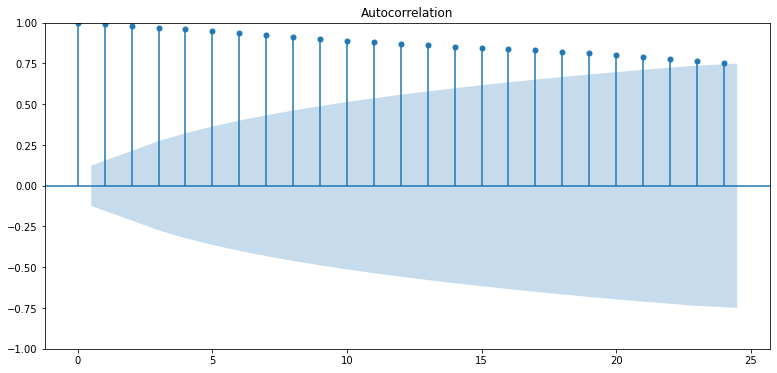

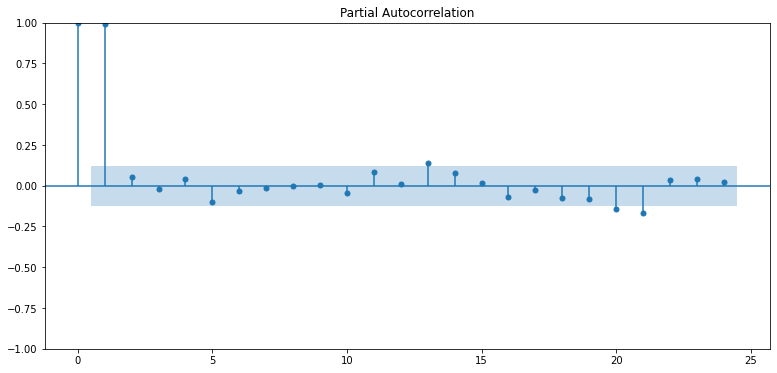

In [9]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


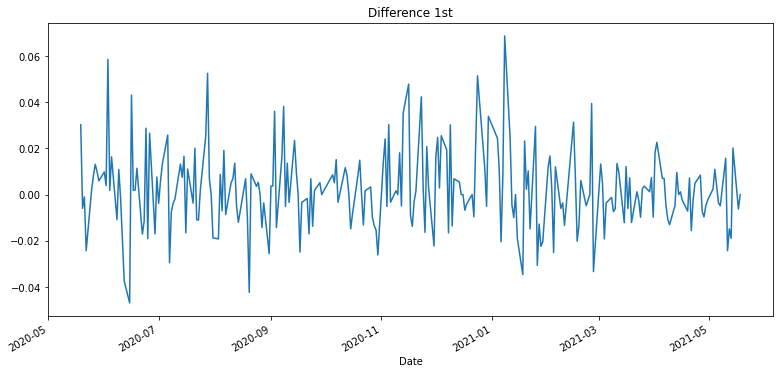

In [10]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

PACF의  경우에 p가 2 이후의 값들은 0에 가까워지기 때문에 p를 0으로 결정하고, ACF에서는 0에 가까워지지 않기 때문에 q는 0으로 두기로 한다. 1차 차분을 구해서 확인한 결과 낮은 p결과로 안정화 상태인 것을 알 수 있기 때문에, d는 1로 설정한다. 

## STEP 6 : ARIMA 모델 훈련과 테스트
이전 단계에서 결정한 ARIMA의 모수로 모델을 만들어서 이용한다. (2,0,1)

In [11]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 583.501
Date:                Thu, 17 Feb 2022   AIC                          -1161.003
Time:                        06:45:19   BIC                          -1150.768
Sample:                             0   HQIC                         -1156.871
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0367      0.062      0.592      0.554      -0.085       0.158
ar.L2         -0.0112      0.076     -0.147      0.883      -0.160       0.138
sigma2         0.0003   2.47e-05     12.961      0.0

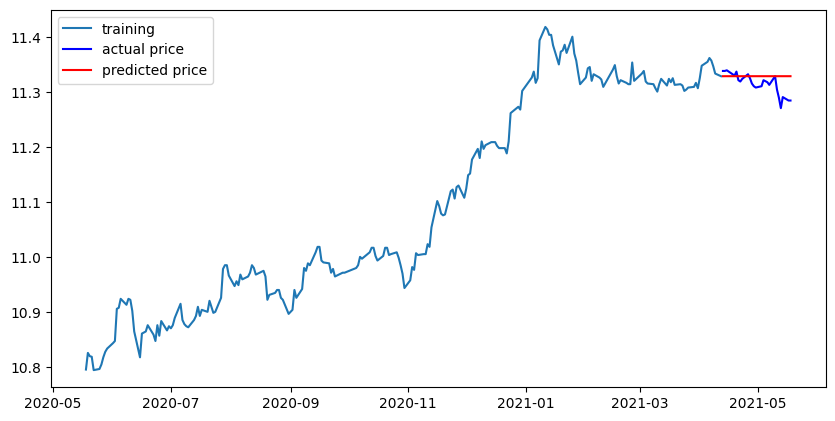

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3514270.8102485035
MAE:  1409.0883491543018
RMSE:  1874.638847951387
MAPE: 1.74%


MAPE가 1% 정도인 것으로 보아, __만족스러운 결과__를 얻었다는 것을 알 수 있다. 사실 실제 모양이랑 좀 다른 것 같은데 MAPE가 기대 이상으로 낮게 나와서 조금 놀랐다.   
  
이제 다른 종목으로 이와 같은 절차를 반복해서 주식을 예측해본다. ARIMA의 적절한 모수를 결정하는 것 이외의 모든 작업은 __동일하게__ 진행한다. 

## 2) 게임스탑 (GME/GameStop Corp.) 주식 예측

## STEP 1. 시계열 데이터 준비

In [14]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/EX11/GME.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    45.939999
2021-02-18    40.689999
2021-02-19    40.590000
2021-02-22    46.000000
2021-02-23    44.970001
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [15]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치는 __없다__는 것을 확인할 수 있다. 로그 변환 후에 데이터는 그대로 이용하겠다. 

In [16]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

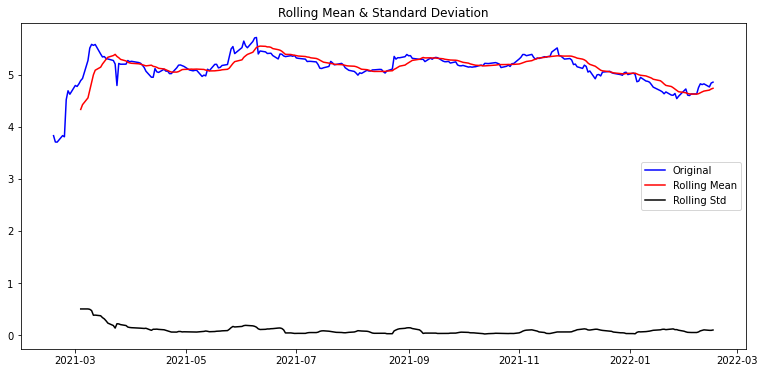

Results of Dickey-Fuller Test:
Test Statistic                  -5.092176
p-value                          0.000015
#Lags Used                       1.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


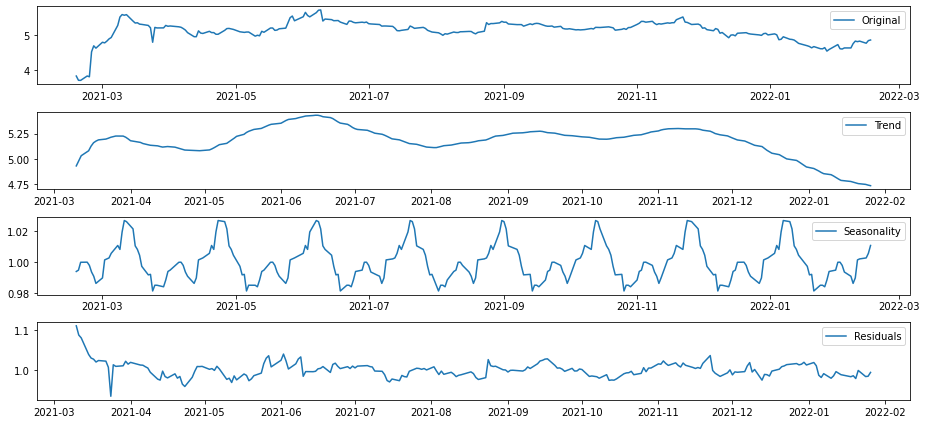

In [17]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.452286e+00
p-value                        5.629307e-11
#Lags Used                     0.000000e+00
Number of Observations Used    2.230000e+02
Critical Value (1%)           -3.460019e+00
Critical Value (5%)           -2.874590e+00
Critical Value (10%)          -2.573725e+00
dtype: float64


시계열의 안정성이 굉장히 낮은 p-value로 보증이 된다. 

## STEP 4 : 학습, 테스트 데이터셋 생성
학습과 테스트 데이터를 9:1로 나누어서 다음과 같이 그래프로 표현된다. 

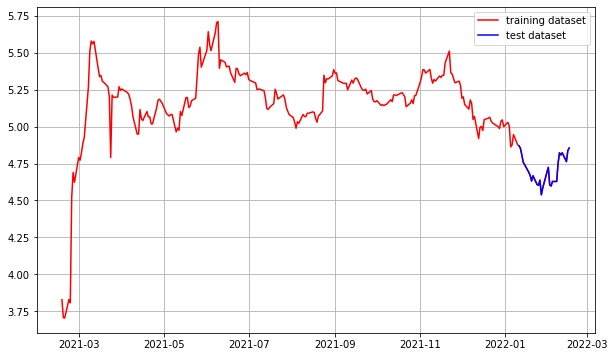

In [19]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF(Autocorrelation Function)과 PACF(Partial Autocorrelation Function)을 구하여 ARIMA의 모수인 p와 q를 결정한다. 이후에, 1차 또는 2차 차분까지 구해서 시계열이 안정된 상태이면 그 차수가 모수 d가 된다. 

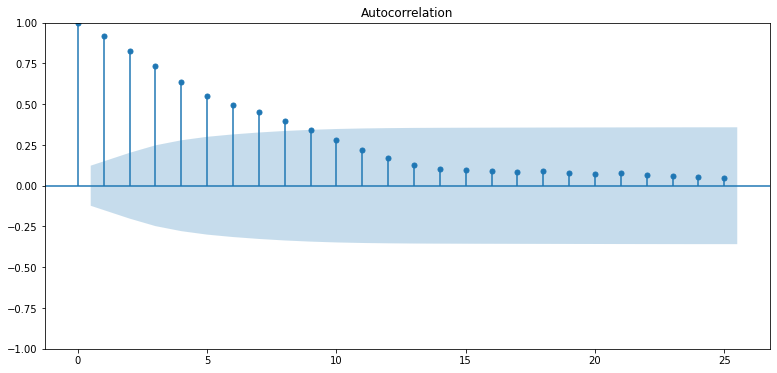

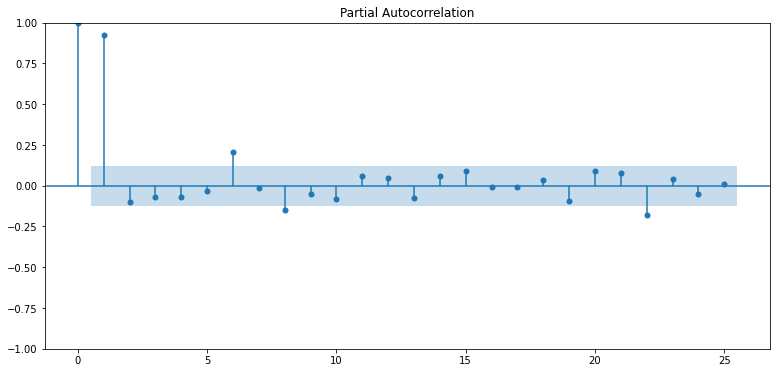

In [20]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.573779e+01
p-value                        1.266568e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


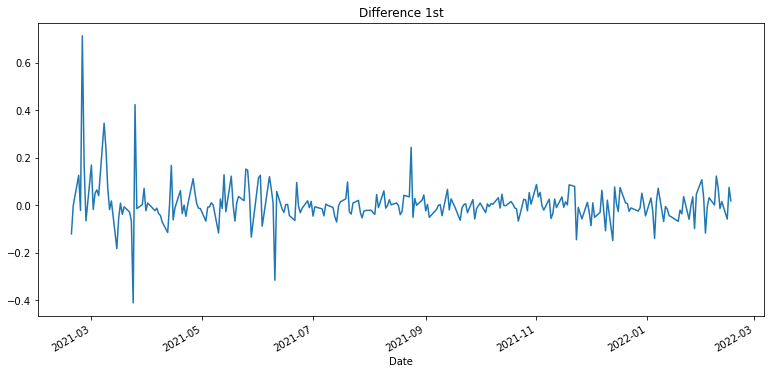

In [21]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

PACF의  경우에 p가 2 이후의 값들은 0에 가까워지기 때문에 p를 0으로 결정하고, ACF에서는 13이후로 0에 특히 가까워지기 때문에 q는 13으로 설정한다. 1차 차분을 구해서 확인한 결과 낮은 p결과로 안정화 상태인 것을 알 수 있기 때문에, d는 1로 설정한다. 

## STEP 6 : ARIMA 모델 훈련과 테스트
이전 단계에서 결정한 ARIMA의 모수로 모델을 만들어서 이용한다. (p,d,q) = (2,1,13)

In [22]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 13))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                ARIMA(2, 1, 13)   Log Likelihood                 232.304
Date:                Thu, 17 Feb 2022   AIC                           -432.608
Time:                        06:45:24   BIC                           -377.809
Sample:                             0   HQIC                          -410.496
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3056      0.204     -6.402      0.000      -1.705      -0.906
ar.L2         -0.8118      0.170     -4.770      0.000      -1.145      -0.478
ma.L1          1.3336      0.219      6.094      0.0

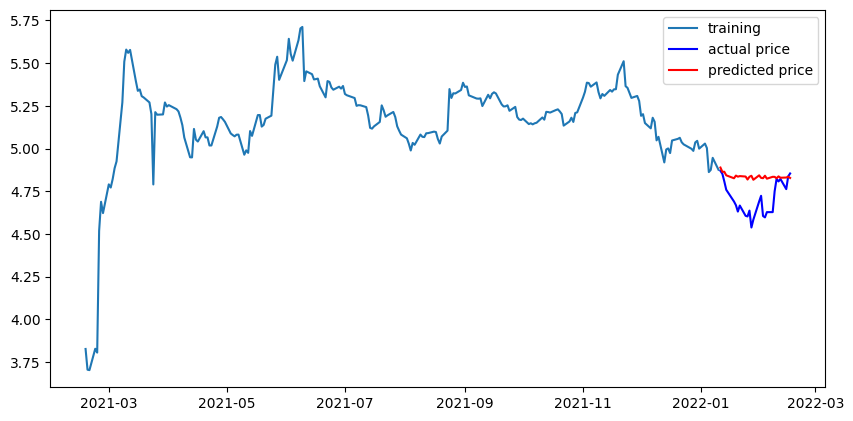

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  321.93338768088904
MAE:  14.90499358280447
RMSE:  17.942502269217886
MAPE: 14.37%


MAPE가 조금 높지만 그래도 15이하로 나온다. 모수를 좀 바꾸어보면서 결과가 나아지는지 확인해보겠다. 

Results of Dickey-Fuller Test:
Test Statistic                -6.840282e+00
p-value                        1.798566e-09
#Lags Used                     1.100000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


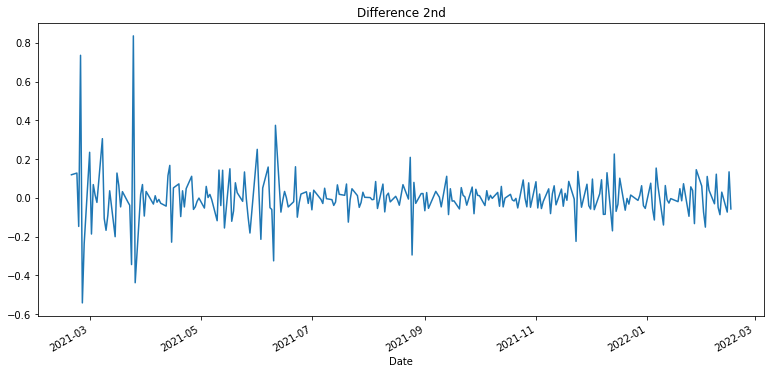

In [25]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d의 값을 2로 설정해보고 다시 확인해보겠다. 

In [26]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 2, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 196.690
Date:                Thu, 17 Feb 2022   AIC                           -387.379
Time:                        06:45:25   BIC                           -377.118
Sample:                             0   HQIC                          -383.238
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7117      0.042    -16.809      0.000      -0.795      -0.629
ar.L2         -0.3955      0.041     -9.594      0.000      -0.476      -0.315
sigma2         0.0102      0.000     27.264      0.0

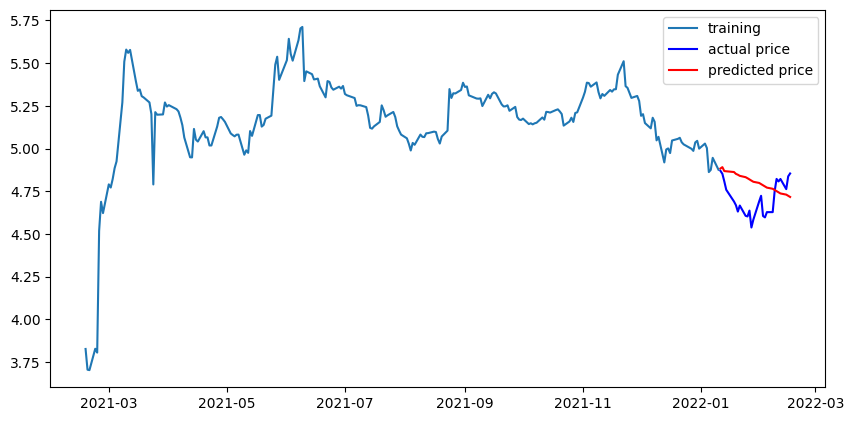

In [27]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  288.44683243021376
MAE:  15.047043921297469
RMSE:  16.983722572811114
MAPE: 14.19%


q와 p 값 중 한 개는 0인 것이 더 좋다는 얘기가 있어 q를 0으로 바꾸었더니 더 좋은 결과가 나왔다. 다음 주식으로 넘어가겠다. 

# 3) 코세라 (COUR / Coursera) 주식 예측

## STEP 1. 시계열 데이터 준비

In [29]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/EX11/COUR.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-03-31    45.000000
2021-04-01    45.779999
2021-04-05    49.610001
2021-04-06    56.230000
2021-04-07    58.000000
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [30]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치는 __없다__는 것을 확인할 수 있다. 로그 변환 후에 데이터는 그대로 이용하겠다. 

In [31]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

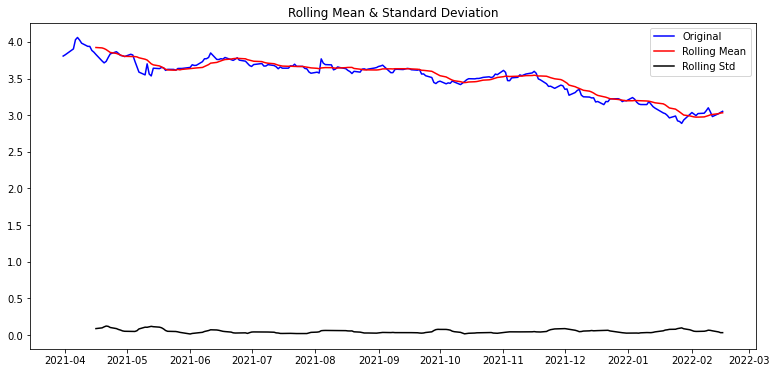

Results of Dickey-Fuller Test:
Test Statistic                  -1.007140
p-value                          0.750651
#Lags Used                       4.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


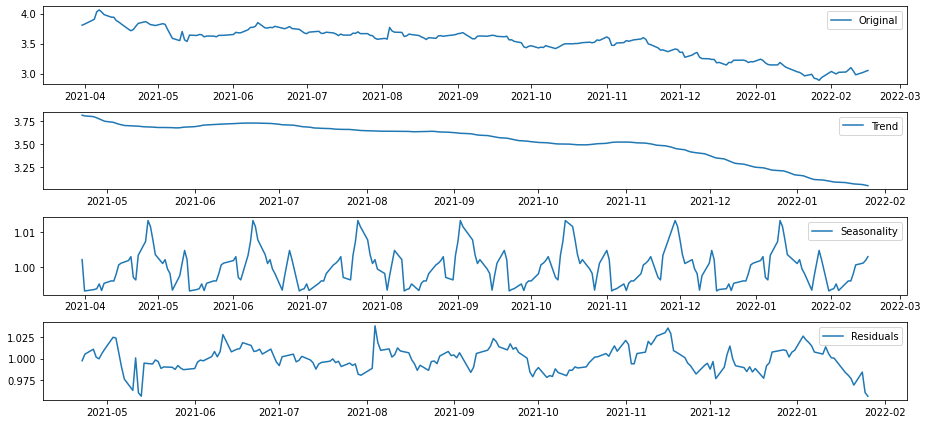

In [32]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [33]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.724108
p-value                          0.000076
#Lags Used                       0.000000
Number of Observations Used    193.000000
Critical Value (1%)             -3.464694
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
dtype: float64


p-value가 이전 사례들보다 높은 편이기는 하지만, 그래도 충분히 낮은 값이다. 시계열은 안정적인 것을 알 수 있다. 

## STEP 4 : 학습, 테스트 데이터셋 생성
학습과 테스트 데이터를 9:1로 나누어서 다음과 같이 그래프로 표현된다. 

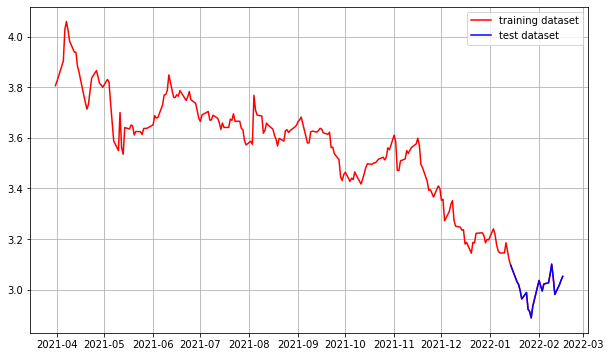

In [34]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF(Autocorrelation Function)과 PACF(Partial Autocorrelation Function)을 구하여 ARIMA의 모수인 p와 q를 결정한다. 이후에, 1차 또는 2차 차분까지 구해서 시계열이 안정된 상태이면 그 차수가 모수 d가 된다. 

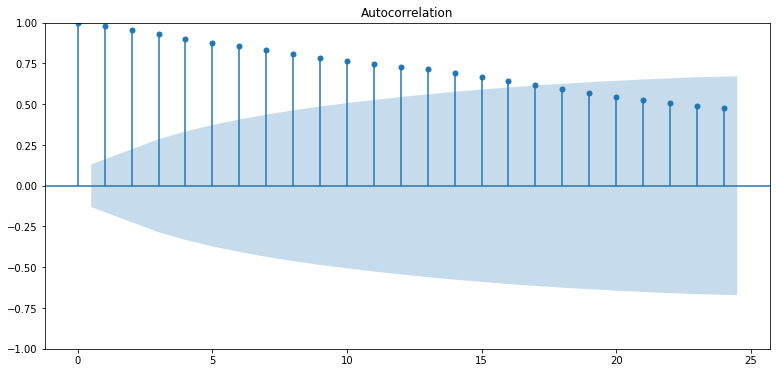

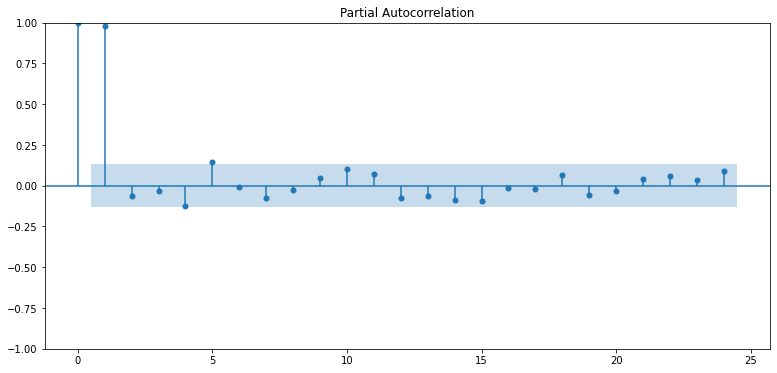

In [35]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.659081e+00
p-value                        1.368860e-16
#Lags Used                     3.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


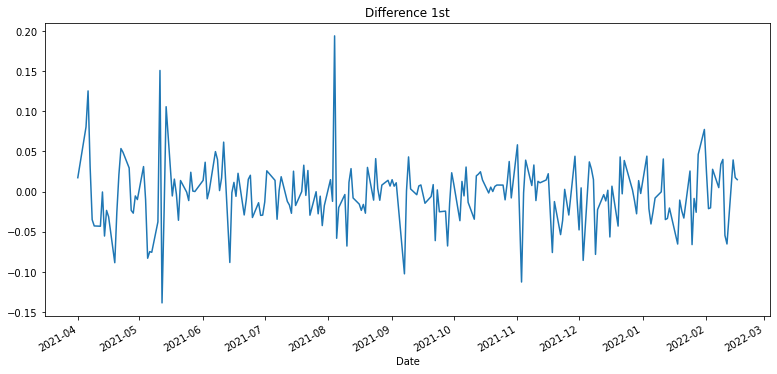

In [36]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

PACF의  경우에 p가 2 이후의 값들은 0에 가까워지기 때문에 p를 0으로 결정하고, ACF에서는 0으로 가까워지지 않기 때문에 q는 0으로 설전한다. 1차 차분을 구해서 확인한 결과 낮은 p결과로 안정화 상태인 것을 알 수 있기 때문에, d는 1로 설정한다. 

## STEP 6 : ARIMA 모델 훈련과 테스트
이전 단계에서 결정한 ARIMA의 모수로 모델을 만들어서 이용한다. (p,d,q) = (2,1,0)

In [37]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  201
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 362.255
Date:                Thu, 17 Feb 2022   AIC                           -718.510
Time:                        06:45:27   BIC                           -708.615
Sample:                             0   HQIC                          -714.506
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0170      0.051      0.332      0.740      -0.083       0.117
ar.L2         -0.0618      0.062     -1.002      0.316      -0.183       0.059
sigma2         0.0016   9.12e-05     17.142      0.0

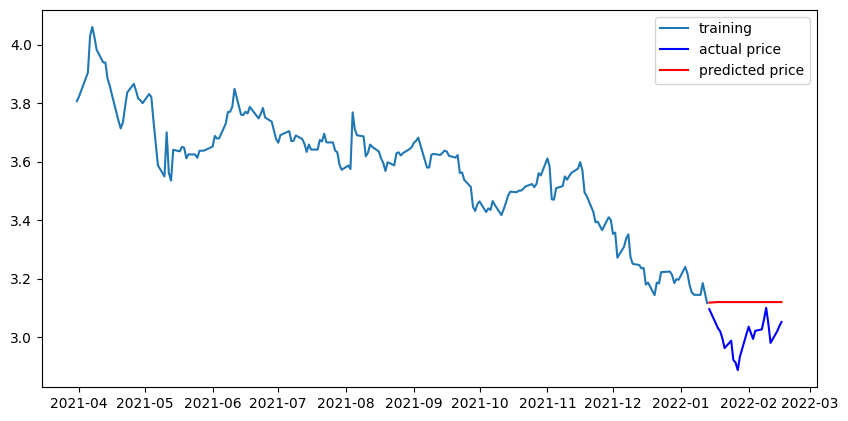

In [38]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6.906051375736527
MAE:  2.4006982022623915
RMSE:  2.627936714560784
MAPE: 12.18%


그래프의 모양은 자연스럽지 못한 직선이지만 또 의외로 MAPE는 15% 이내로 들어온다. 제발 실제로도 저 주식이 저렇게 더 떨어지지 않았으면 좋겠다..

# 3) 네이버 주식 예측

## STEP 1. 시계열 데이터 준비

In [40]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/EX11/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    392000.0
2021-02-18    388000.0
2021-02-19    398000.0
2021-02-22    386500.0
2021-02-23    390500.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [41]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

결측치는 __없다__는 것을 확인할 수 있다. 로그 변환 후에 데이터는 그대로 이용하겠다. 

In [42]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

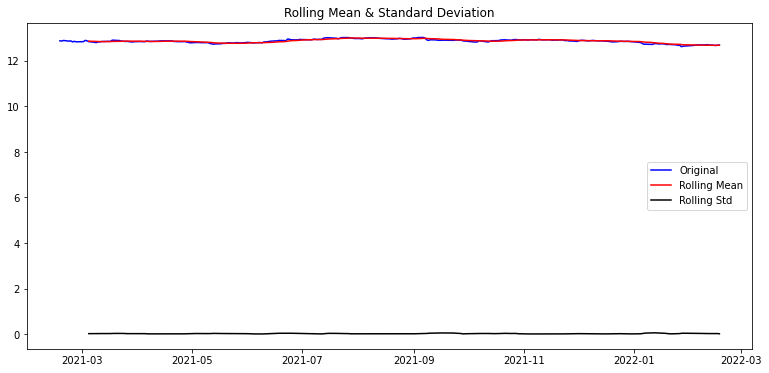

Results of Dickey-Fuller Test:
Test Statistic                  -0.975911
p-value                          0.761949
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


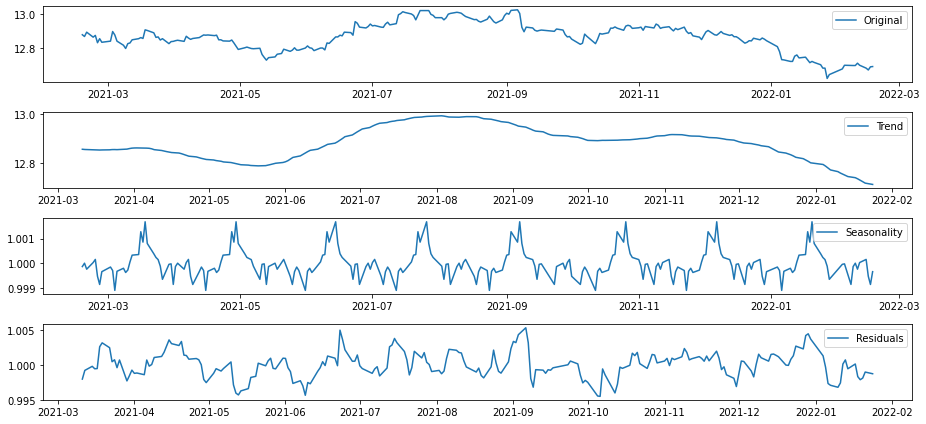

In [43]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [44]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.139357e+00
p-value                        8.041135e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


p-value를 보니 시계열은 안정적이다. 

## STEP 4 : 학습, 테스트 데이터셋 생성
학습과 테스트 데이터를 9:1로 나누어서 다음과 같이 그래프로 표현된다. 

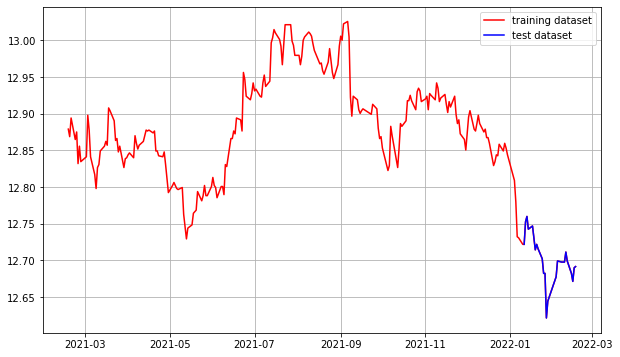

In [45]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF(Autocorrelation Function)과 PACF(Partial Autocorrelation Function)을 구하여 ARIMA의 모수인 p와 q를 결정한다. 이후에, 1차 또는 2차 차분까지 구해서 시계열이 안정된 상태이면 그 차수가 모수 d가 된다. 

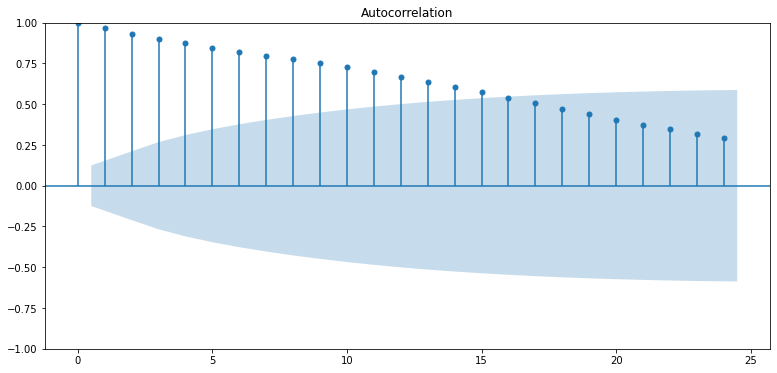

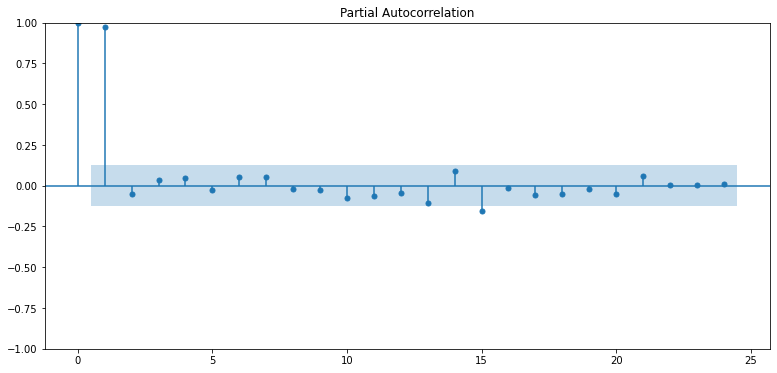

In [46]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.202195e+01
p-value                        3.009162e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


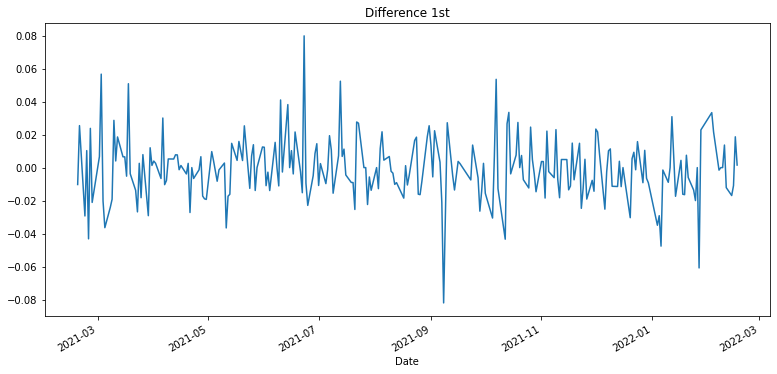

In [47]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

PACF의  경우에 p가 2 이후의 값들은 0에 가까워지기 때문에 p를 0으로 결정하고, ACF에서는 0으로 가까워지지 않기 때문에 q는 0으로 설전한다. 1차 차분을 구해서 확인한 결과 낮은 p결과로 안정화 상태인 것을 알 수 있기 때문에, d는 1로 설정한다. 

## STEP 6 : ARIMA 모델 훈련과 테스트
이전 단계에서 결정한 ARIMA의 모수로 모델을 만들어서 이용한다. (p,d,q) = (2,1,0)

In [48]:
# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 566.387
Date:                Thu, 17 Feb 2022   AIC                          -1126.774
Time:                        06:45:29   BIC                          -1116.566
Sample:                             0   HQIC                         -1122.653
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0369      0.067      0.549      0.583      -0.095       0.169
ar.L2         -0.0963      0.059     -1.624      0.104      -0.213       0.020
sigma2         0.0004   2.26e-05     15.778      0.0

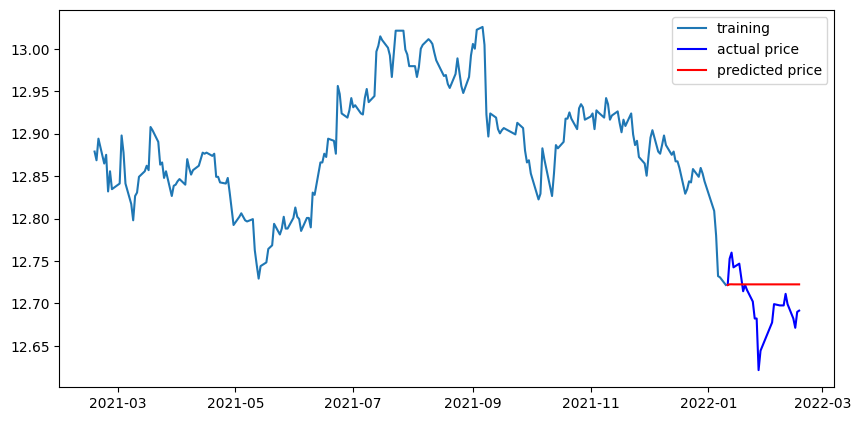

In [49]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  147813233.22614348
MAE:  9840.167097959451
RMSE:  12157.846570266605
MAPE: 3.05%


마지막으로 예측한 네이버의 주식도 직선 형태로 나왔다. 하지만 또 의의로 MAPE점수가 굉장히 낮다. 주식 예측은 어렵다는 생각이 계속 든다. 

## 회고
* 이번에 처음으로 시계열에 대해서 배우게 되었다. 노드에서 시계열의 전반적인 특성과 분석 방법에 대해서 배울 수 있었고, 주식에 대한 데이터를 바탕으로 주식을 예측해볼 수도 있었다. 하지만 이번에 실제 주식 데이터로 예측을 해보니까 MAPE는 생각보다 작게 나와도 그래프를 봤을 때 실제 추세랑은 다른 형태, 특히 직선 형태로 선이 그려지는 것을 확인할 수 있었다. 아무래도 이건 데이터의 부족함에서 나온 것이 아닐까라고 추측해본다. 이번 노드에서 사용한 데이터는 결국 주식 가격에 대한 정보만 이용하여 추세를 파악해서 미래의 가격을 예측한 것인데, 실제로는 주식의 가격에 영향을 미치는 요소는 너무나도 많다. 하지만 이런 복잡한 관계를 단순히 이전의 추세만을 이용하여 정확한 예측이 나오기를 기대하기에는 무리가 있는 것 같다.
* 사실 ARIMA의 모수를 결정하는데 ACF와 PACF를 어떤 이유로 참고하는 건지 정확하게는 모르겠다. 노드에서 제시한 기준을 바탕으로 모수를 결정해서 원하는 결과를 얻어내긴 했지만, 이 부분은 조금 더 공부가 필요할 것 같다. 
* 이 노트북에서 삼성전자, 게임스탑, 코세라, 네이버 4가지의 주식 가격을 예측해보았는데, 게임스탑을 제외한 나머지 3 경우는 모두 직선과 비슷한 형태로 예측이 되었다. 왜 게임스탑만 다른 형태로 나왔고, 나머지는 직선으로 예측이 되었는지 이유가 궁금하다. 